In [1]:
import pandas as pd
import os
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

def compute_monthly_avg_pos_score(file_path):
    df = pd.read_csv(file_path)

    # 'dt' 열을 datetime 형식으로 변환
    df['Date'] = pd.to_datetime(df['Date'])

    # 'dt' 열에서 월 정보 추출하여 'month' 열 생성
    df['month'] = df['Date'].dt.to_period('M')
    # name과 month별로 pos_score의 평균 계산
    monthly_avg_pos_score = df.groupby(['company', 'month'])['Positive_Score'].mean().reset_index()

    # name별로 code 값 매핑
    code_mapping = df[['company', 'code']].drop_duplicates().set_index('company')['code']
    monthly_avg_pos_score['code'] = monthly_avg_pos_score['company'].map(code_mapping)
    
    # monthly_avg_pos_score에 레이블 열 추가
    monthly_avg_pos_score['label'] = ''
    monthly_avg_pos_score['Positive_Score_Change'] = monthly_avg_pos_score.groupby('company')['Positive_Score'].diff()
    
    # 월별로 반복하며 상위 10%와 하위 10%에 해당하는 종목 찾기
    for month in monthly_avg_pos_score['month'].unique():
        # 해당 월 데이터 필터링
        month_data = monthly_avg_pos_score[monthly_avg_pos_score['month'] == month]

        # pos_score 순으로 내림차순 정렬
        month_data_sorted = month_data.sort_values('Positive_Score_Change', ascending=False)

        # 순위(rank) 매기기
        month_data_sorted['rank'] = month_data_sorted['Positive_Score_Change'].rank(method='first', ascending=False)

        # 상위 10%와 하위 10%에 해당하는 종목 찾기
        top_10_pct_cutoff = month_data_sorted['rank'].quantile(0.1)
        bottom_10_pct_cutoff = month_data_sorted['rank'].quantile(0.9)
        top_10_pct_names = month_data_sorted[month_data_sorted['rank'] <= top_10_pct_cutoff]['company'].tolist()
        bottom_10_pct_names = month_data_sorted[month_data_sorted['rank'] >= bottom_10_pct_cutoff]['company'].tolist()

        # 해당 월에 대한 레이블 추가
        monthly_avg_pos_score.loc[(monthly_avg_pos_score['month'] == month) & (monthly_avg_pos_score['company'].isin(top_10_pct_names)), 'label'] = 'Top 10%'
        monthly_avg_pos_score.loc[(monthly_avg_pos_score['month'] == month) & (monthly_avg_pos_score['company'].isin(bottom_10_pct_names)), 'label'] = 'Bottom 10%'
    
    label_order = ['Top 10%', 'Bottom 10%']

    # 새로운 데이터프레임 생성
    labeled_data = monthly_avg_pos_score[monthly_avg_pos_score['label'].isin(label_order)].copy()

    # 월별, 레이블 순으로 정렬
    labeled_data['label'] = pd.Categorical(labeled_data['label'], categories=label_order, ordered=True)
    labeled_data = labeled_data.sort_values(['month', 'label'])
    
    # labeled_data 반복
    for idx, row in labeled_data.iterrows():
        code = row['code'].strip("'")  # 작은따옴표 제거
        month = pd.to_datetime(row['month'], format='%Y-%m')  # month를 Timestamp로 변환

        # 파일 경로 생성
        file_path = f"./stock_data/{code}.csv"

        # 파일이 존재하는지 확인
        if os.path.exists(file_path):
            # 파일 읽어오기
            stock_data = pd.read_csv(file_path)
            stock_data['Date'] = pd.to_datetime(stock_data['Date'])

            # 다음 달의 시작일과 종료일 계산
            next_month_start = month + pd.offsets.MonthBegin(1)
            next_month_end = next_month_start + pd.offsets.MonthEnd(1)
            mask = (stock_data['Date'] >= next_month_start) & (stock_data['Date'] < next_month_end)

            # 다음 달의 데이터 필터링
            filtered_data = stock_data.loc[mask]

            # 필터링된 데이터가 있는지 확인
            if not filtered_data.empty:
                # 첫 번째 날과 마지막 날의 종가 가져오기
                first_day_close = filtered_data.iloc[0]['Open']
                last_day_close = filtered_data.iloc[-1]['Close']

                # 새로운 열에 값 저장
                labeled_data.at[idx, 'First'] = first_day_close
                labeled_data.at[idx, 'Last'] = last_day_close
            else:
                print(f"Code: {code}, Month: {month.strftime('%Y-%m')}, No data for the next month.")
        else:
            print(f"Code: {code}, Month: {month.strftime('%Y-%m')}, CSV file not found.")
            
    return labeled_data


In [2]:
def calculate_pct(labeled_data,file_path):
    data = os.path.basename(file_path)
    data= os.path.splitext(data)[0]
    directory = f'./result/{data}'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # 'pct' 열 추가
    labeled_data['pct'] = 0.0

    # 'First'와 'Last' 열 비교하여 'pct' 열 계산
    labeled_data['pct'] = (labeled_data['Last'] - labeled_data['First']) / labeled_data['First'] * 100

    # inf 값을 가지거나 없는 행 제거
    labeled_data = labeled_data.replace([float('inf'), -float('inf')], pd.NA)
    labeled_data.dropna(subset=['pct'], inplace=True)

    # 'Top 10%' label에 해당하는 행들 선택
    top_10_data = labeled_data[labeled_data['label'] == 'Top 10%']

    # 다중 인덱싱을 사용하여 월별, label별 평균 pct 계산
    avg_pct = labeled_data.groupby([labeled_data['month'], labeled_data['label']])['pct'].mean().reset_index()

    # 'Top 10%' label에 해당하는 행들 선택
    top_10_data = avg_pct[avg_pct['label'] == 'Top 10%']

    # 'Bottom 10%' label에 해당하는 행들 선택
    bottom_10_data = avg_pct[avg_pct['label'] == 'Bottom 10%']

    # 'Top 10%' label의 월별 수익률 계산
    top_10_monthly_pct = top_10_data.groupby(top_10_data['month'])['pct'].mean().reset_index()

    # 'Bottom 10%' label의 월별 수익률 계산
    bottom_10_monthly_pct = bottom_10_data.groupby(bottom_10_data['month'])['pct'].mean().reset_index()
    kospi = pd.read_csv("./data/Kospi_2021_2023.csv")

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(len(top_10_monthly_pct)), top_10_monthly_pct['pct'], label='Top 10%', alpha=0.7)  # 투명도 조절
    ax.bar(range(len(bottom_10_monthly_pct)), bottom_10_monthly_pct['pct'], label='Bottom 10%', alpha=0.7)  # 투명도 조절
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Return (%)')
    ax.set_title("'Top 10%' and 'Bottom 10%' Increament Monthly Returns")
    ax.set_xticks(range(len(top_10_monthly_pct)))
    ax.set_xticklabels(top_10_monthly_pct['month'].dt.strftime('%Y-%m'))
    plt.xticks(rotation=45)
    ax.plot(range(len(kospi)), kospi['pct'], label='KOSPI', marker='o', linestyle='-', color='r')
    ax.legend()
    plt.savefig(f'{directory}/{data}_Increament_Top10%_Bottom10%_Kospi_returns.png')
    
    return avg_pct
    


In [3]:
def evalueate_porto(labeled_data,file_path):
    data = os.path.basename(file_path)
    data= os.path.splitext(data)[0]
    directory = f'./result/{data}'
    
    kospi_df = pd.read_csv("./data/Kospi_2021_2023.csv")
    kospi_df['month'] = pd.to_datetime(kospi_df['month'], format='%Y-%m')
    
    initial_investment = 100000

    # BH 전략 적용
    kospi_df['BH_Value'] = initial_investment  # 첫 달에는 초기 투자금액으로 설정
    kospi_df['BH_Return'] = ((kospi_df.iloc[0]['Last'] - kospi_df.iloc[0]['First']) / kospi_df.iloc[0]['First']) * 100  # 첫 달 수익률 계산

    first_day_close = kospi_df.iloc[0]['First']  # 첫 행의 'First' 값

    for i in range(0, len(kospi_df)):
        kospi_df.at[i, 'BH_Value'] = initial_investment * (kospi_df.iloc[i]['Last'] / first_day_close)
        kospi_df.at[i, 'BH_Return'] = (kospi_df.iloc[i]['BH_Value'] - initial_investment) / initial_investment * 100
        
    top_10_monthly_pct = labeled_data[labeled_data['label'] == 'Top 10%'].groupby('month')['pct'].mean().reset_index()
    top_10_monthly_pct['Long Only'] = initial_investment
    for i in range(len(top_10_monthly_pct)):
        if i == 0:
            top_10_monthly_pct.at[i, 'Long Only'] = initial_investment * (1 + top_10_monthly_pct.iloc[i]['pct']/100)
        else:
            top_10_monthly_pct.at[i, 'Long Only'] = top_10_monthly_pct.iloc[i-1]['Long Only'] * (1 + top_10_monthly_pct.iloc[i]['pct']/100)

    bottom_10_monthly_pct = labeled_data[labeled_data['label'] == 'Bottom 10%'].groupby('month')['pct'].mean().reset_index()
    bottom_10_monthly_pct['Short Only'] = initial_investment
    for i in range(len(bottom_10_monthly_pct)):
        if i == 0:
            bottom_10_monthly_pct.at[i, 'Short Only'] = initial_investment * (1 - bottom_10_monthly_pct.iloc[i]['pct']/100)
        else:
            bottom_10_monthly_pct.at[i, 'Short Only'] = bottom_10_monthly_pct.iloc[i-1]['Short Only'] * (1 - bottom_10_monthly_pct.iloc[i]['pct']/100)
    
    long_short_pct = top_10_monthly_pct.copy()
    long_short_pct = long_short_pct.drop(['pct','Long Only'], axis=1)
    
    # 월별로 그룹화
    long_short_pct['pct_long'] = top_10_monthly_pct['pct']
    long_short_pct['pct_short'] = -bottom_10_monthly_pct['pct']
    long_short_pct["avg_pct"] = (long_short_pct['pct_short']+long_short_pct['pct_long'])/2
    
    long_short_pct['Long'] = initial_investment * (1 + long_short_pct['pct_long'] / 100)
    long_short_pct['Short'] = initial_investment * (1 + long_short_pct['pct_short'] / 100)
    long_short_pct['Long&Short'] = (long_short_pct['Long'] + long_short_pct['Short']) / 2
    
    for i in range(len(long_short_pct)):
        if i == 0:
            long_short_pct.at[i, 'Long&Short'] = initial_investment * (1 + long_short_pct.iloc[i]['avg_pct']/100)
            long_short_pct.at[i, 'Long'] = initial_investment * (1 + long_short_pct.iloc[i]['pct_long']/100)
            long_short_pct.at[i, 'Short'] = initial_investment * (1 + long_short_pct.iloc[i]['pct_short']/100)
        else:
            long_short_pct.at[i, 'Long&Short'] = long_short_pct.iloc[i-1]['Long&Short'] * (1 + long_short_pct.iloc[i]['avg_pct']/100)
            long_short_pct.at[i, 'Long'] = long_short_pct.iloc[i-1]['Long'] * (1 + long_short_pct.iloc[i]['pct_long']/100)
            long_short_pct.at[i, 'Short'] = long_short_pct.iloc[i-1]['Short'] * (1 + long_short_pct.iloc[i]['pct_short']/100)
    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(10, 6))

    # KOSPI BH_Value 포트폴리오 그리기
    ax.plot(kospi_df['month'].dt.strftime('%Y-%m'), kospi_df['BH_Value'], marker='o', linestyle='-', label='KOSPI BH_Value')

    # 'Long Only' 포트폴리오 그리기
    ax.plot(top_10_monthly_pct['month'].dt.strftime('%Y-%m'), top_10_monthly_pct['Long Only'], marker='o', linestyle='-', label='Long Only')

    # 'Short Only' 포트폴리오 그리기
    ax.plot(bottom_10_monthly_pct['month'].dt.strftime('%Y-%m'), bottom_10_monthly_pct['Short Only'], marker='s', linestyle='--', label='Short Only')

    # 'Long&Short' 포트폴리오 그리기
    ax.plot(long_short_pct['month'].dt.strftime('%Y-%m'), long_short_pct['Long&Short'], marker='^', linestyle='-.', label='Long&Short')

    # 그래프 옵션 설정
    ax.set_xlabel('Month')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'{data} Increament Portfolio Performance: KOSPI BH_Value vs Long Only vs Short Only vs Long&Short')
    ax.legend()
    plt.xticks(rotation=45)   
    plt.savefig(f'{directory}/{data}_Increament_returns.png')
    # top_10_monthly_pct (Long Only 전략) 저장
    long_short_pct.to_csv(f'./result/{data}/{data}_Increament.csv', index=False)
    
    return long_short_pct
        
  


In [4]:
file_path = './data\\Claude3-haiku.csv'

Code: 383220, Month: 2021-03, No data for the next month.
Code: 137310, Month: 2021-03, No data for the next month.
Code: 395400, Month: 2021-04, No data for the next month.
Code: 454910, Month: 2021-04, No data for the next month.
Code: 395400, Month: 2021-05, No data for the next month.
Code: 402340, Month: 2021-06, No data for the next month.
Code: 259960, Month: 2021-06, No data for the next month.
Code: 454910, Month: 2021-06, No data for the next month.
Code: 454910, Month: 2021-07, No data for the next month.
Code: 373220, Month: 2021-08, No data for the next month.
Code: 402340, Month: 2021-08, No data for the next month.
Code: 377300, Month: 2021-09, No data for the next month.
Code: 373220, Month: 2021-09, No data for the next month.
Code: 402340, Month: 2021-09, No data for the next month.
Code: 454910, Month: 2021-10, No data for the next month.
Code: 454910, Month: 2021-11, No data for the next month.
Code: 454910, Month: 2021-12, No data for the next month.
Code: 278470, 

Code: 278470, Month: 2023-01, No data for the next month.
Code: 454910, Month: 2023-02, No data for the next month.
Code: 278470, Month: 2023-02, No data for the next month.
Code: 454910, Month: 2023-03, No data for the next month.
Code: 454910, Month: 2023-04, No data for the next month.
Code: 454910, Month: 2023-06, No data for the next month.
Code: 278470, Month: 2023-06, No data for the next month.
Code: 278470, Month: 2023-07, No data for the next month.
Code: 454910, Month: 2023-08, No data for the next month.
Processing completed for ./data\KB-ALbert.csv

Error processing ./data\Kospi_2021_2023.csv: 'Date'

Error processing ./data\Kospi_week_2021_2023.csv: 'Date'

Code: 383220, Month: 2021-02, No data for the next month.
Code: 278470, Month: 2021-02, No data for the next month.
Code: 383220, Month: 2021-03, No data for the next month.
Code: 395400, Month: 2021-04, No data for the next month.
Code: 259960, Month: 2021-04, No data for the next month.
Code: 137310, Month: 2021-04, 

C:\Users\GCU\AppData\Local\Temp\ipykernel_4756\83545804.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


Processing completed for ./data\LLAMA3-8B-CL.csv



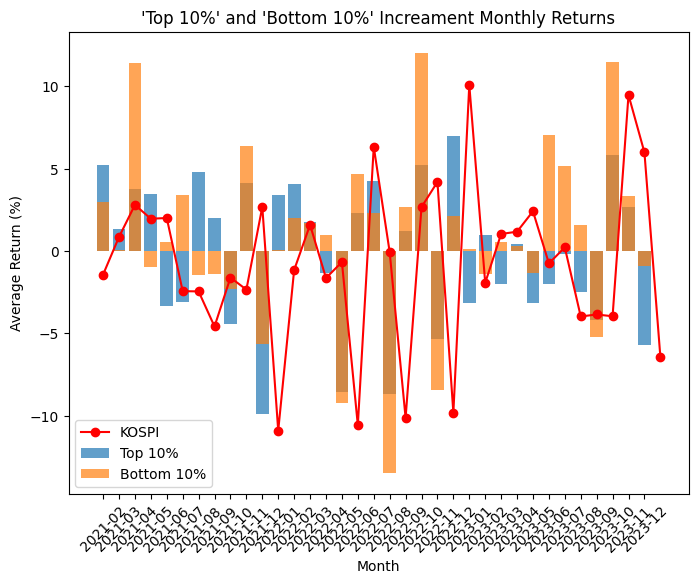

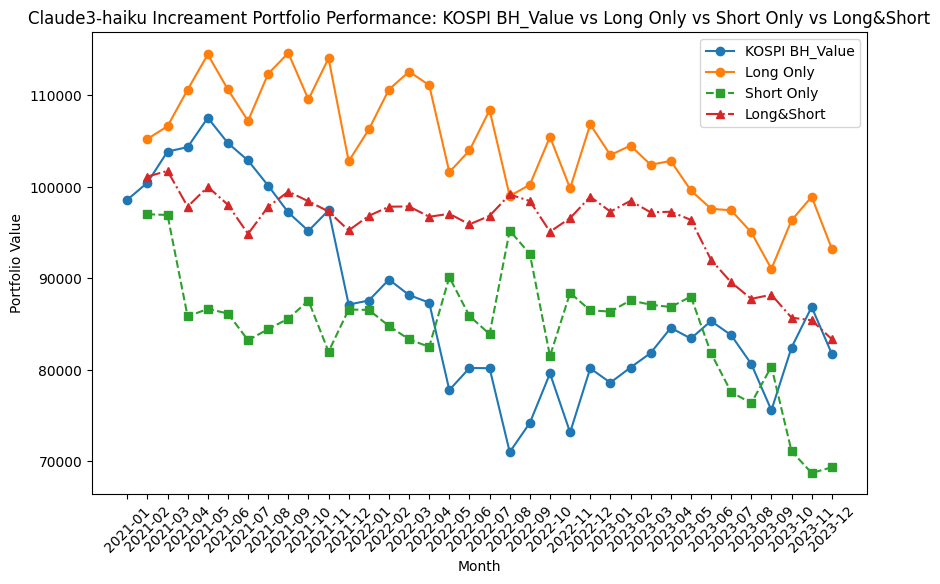

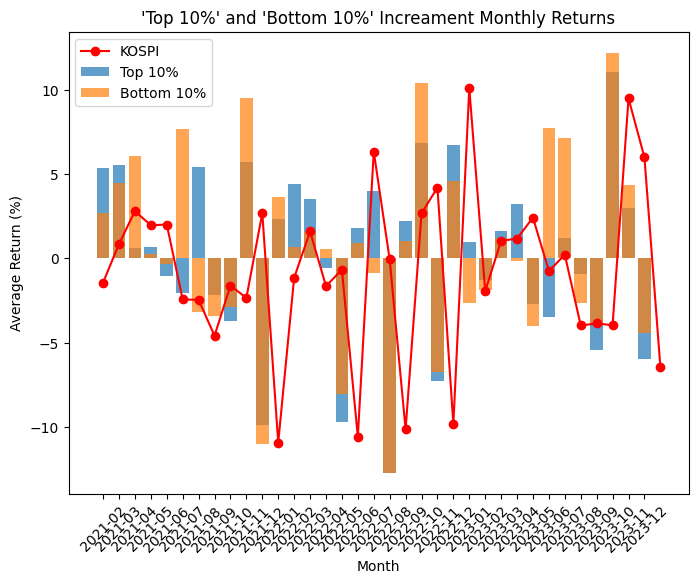

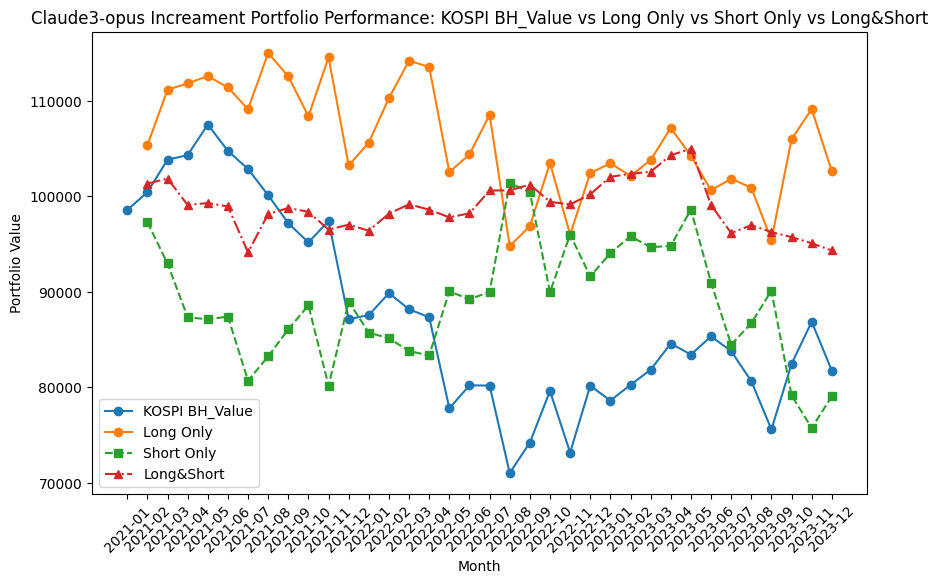

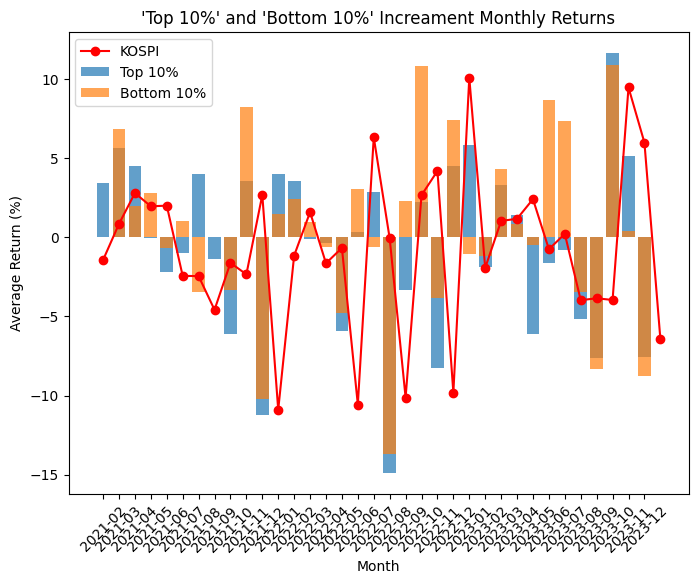

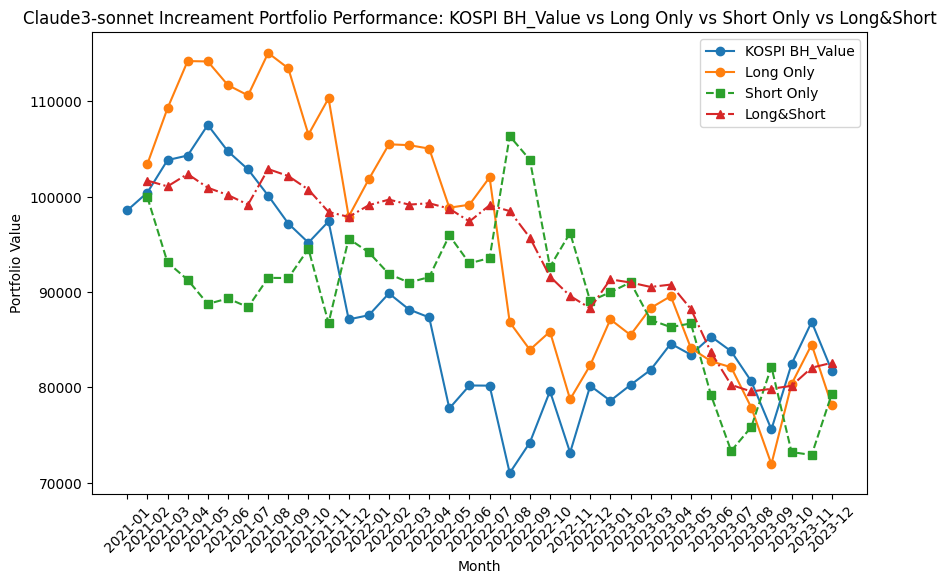

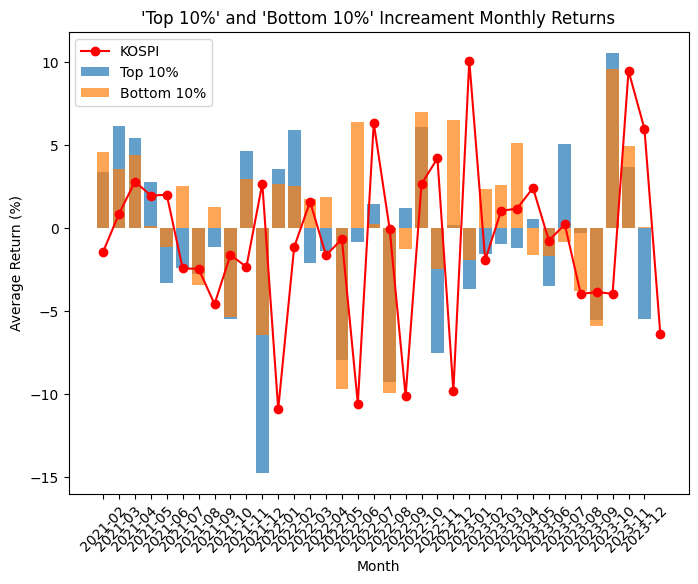

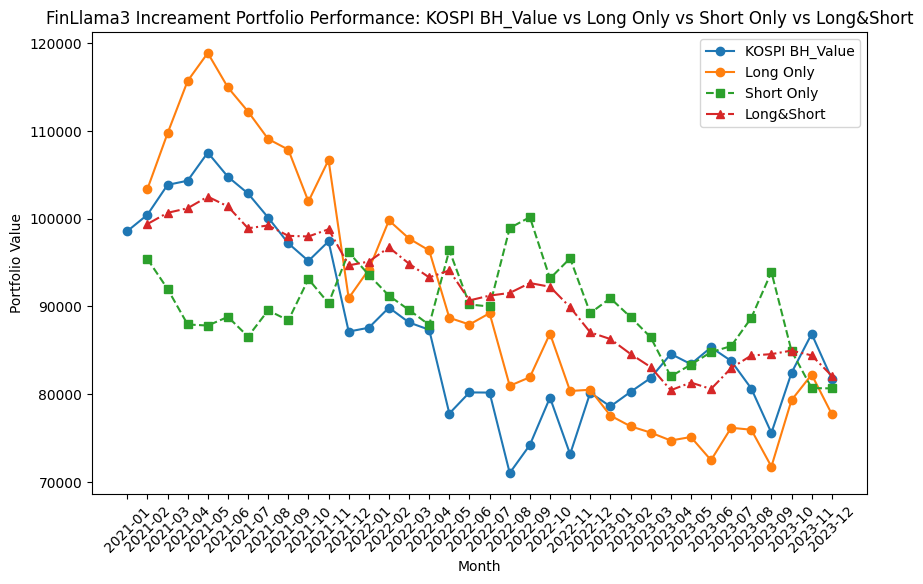

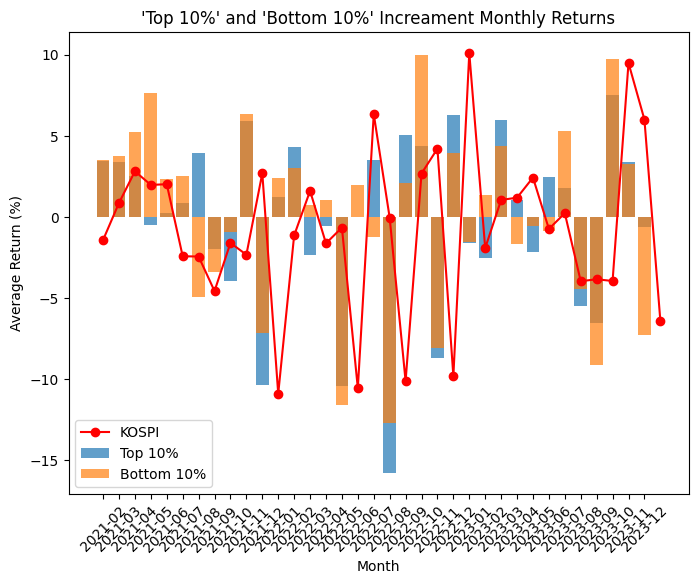

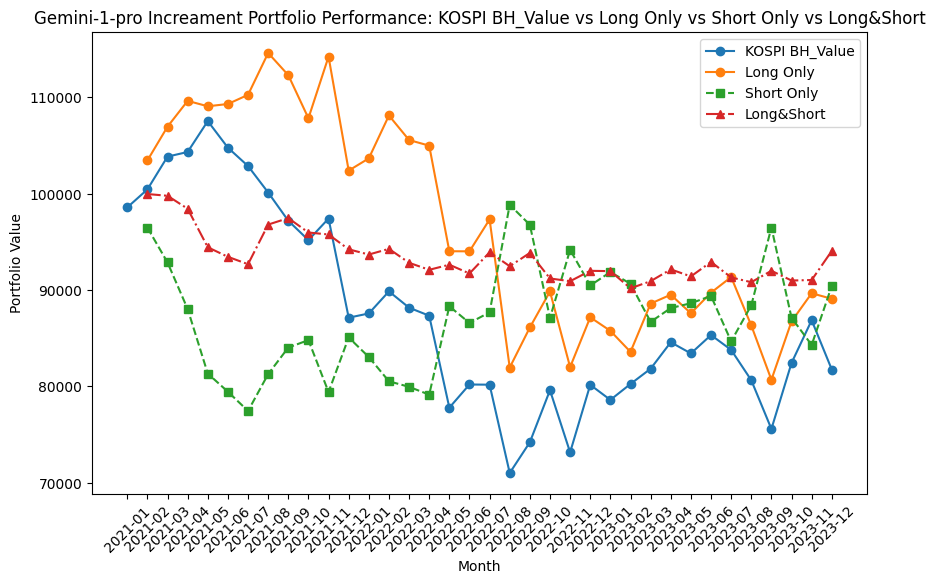

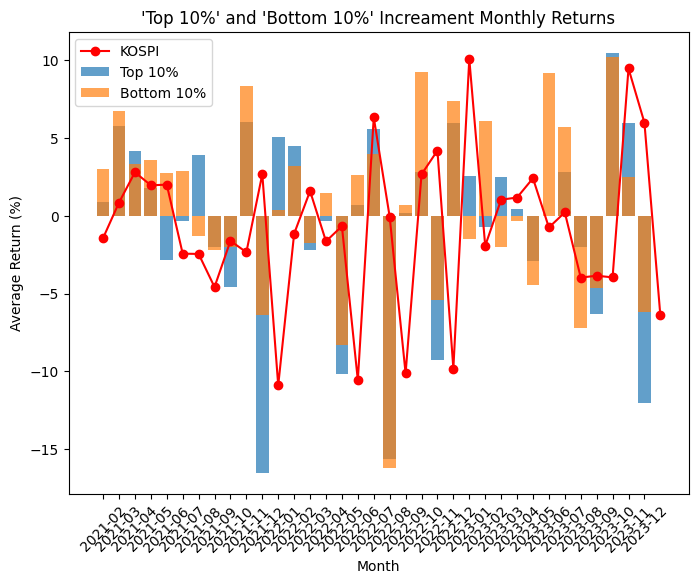

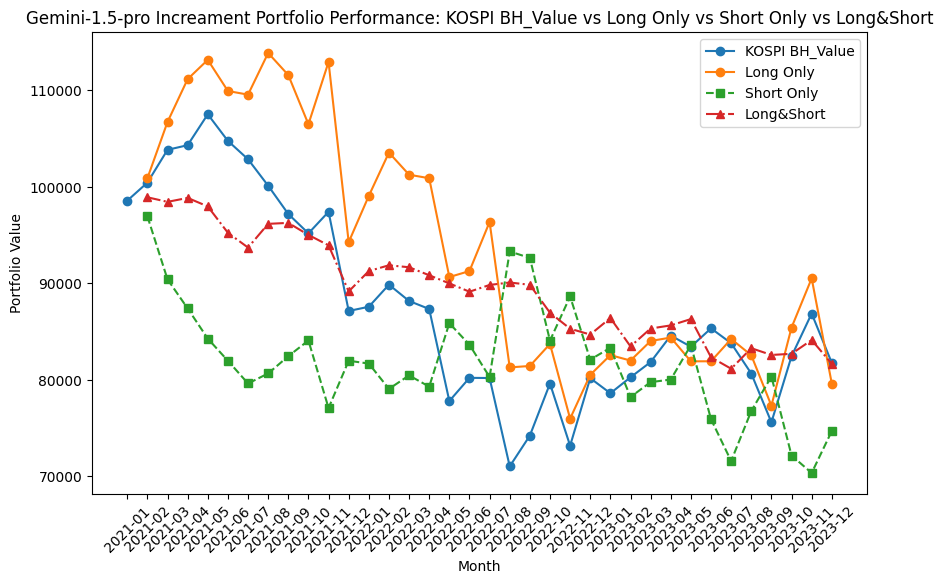

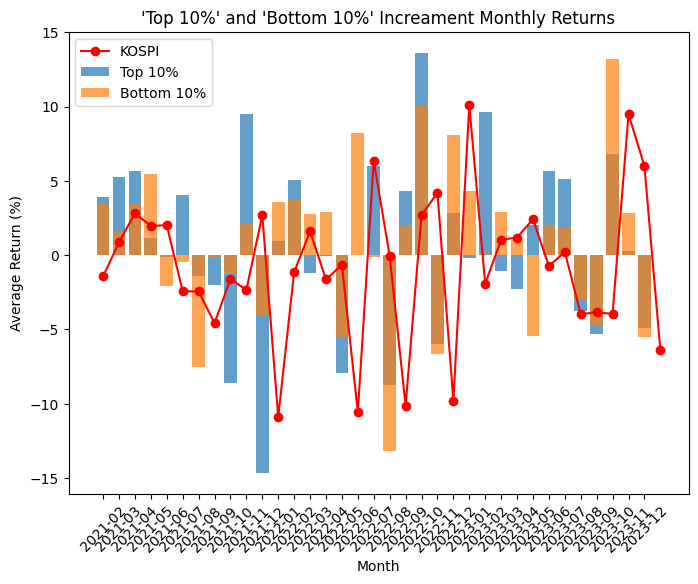

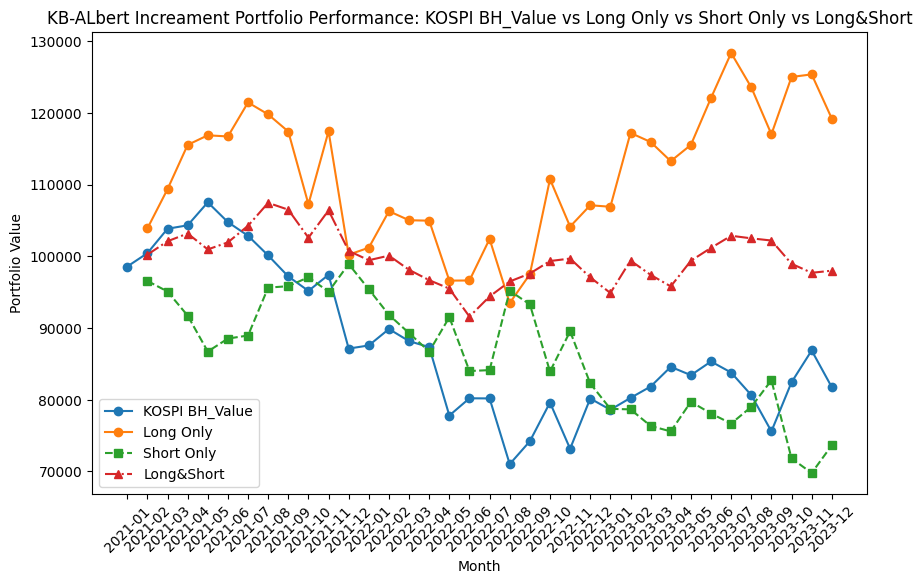

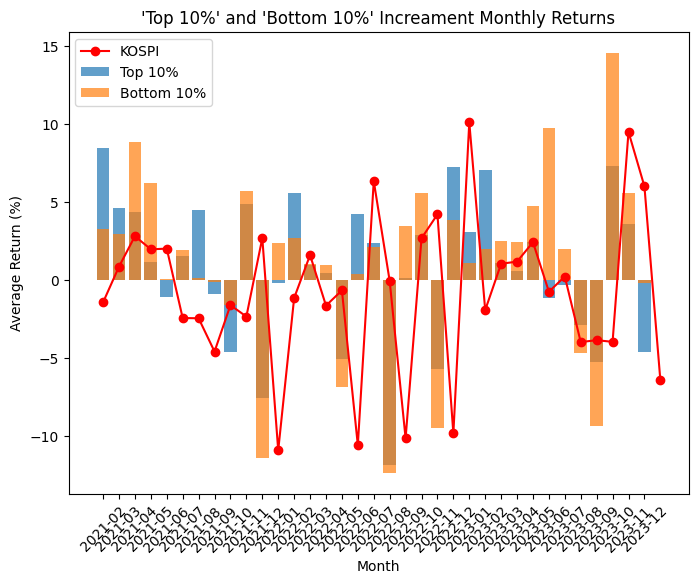

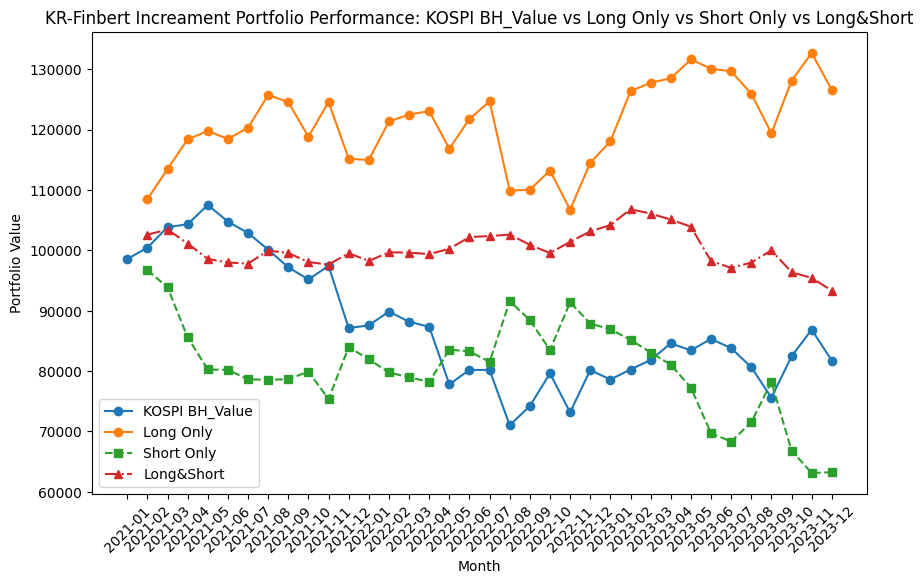

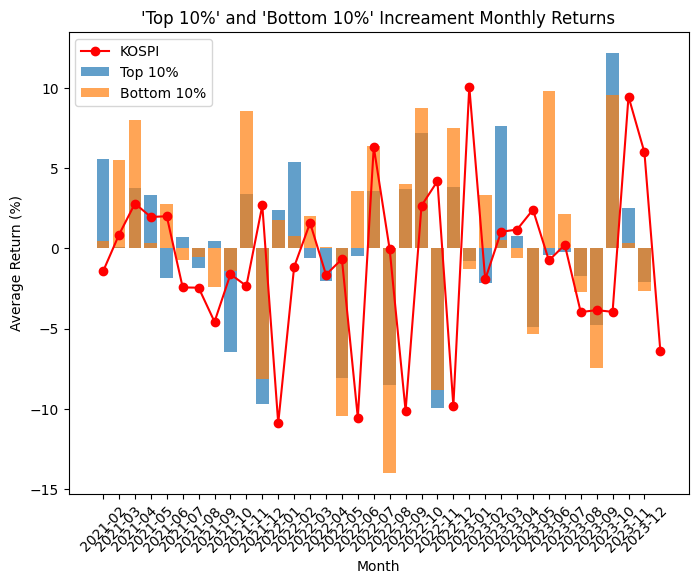

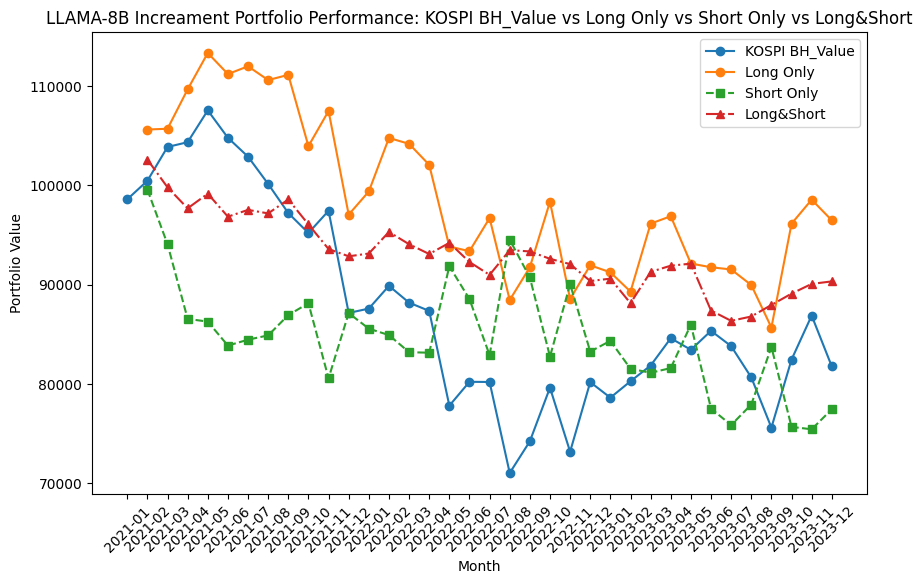

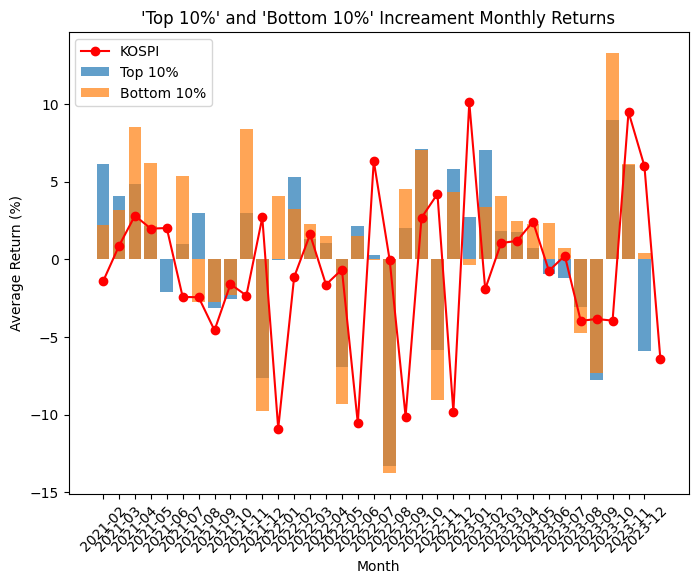

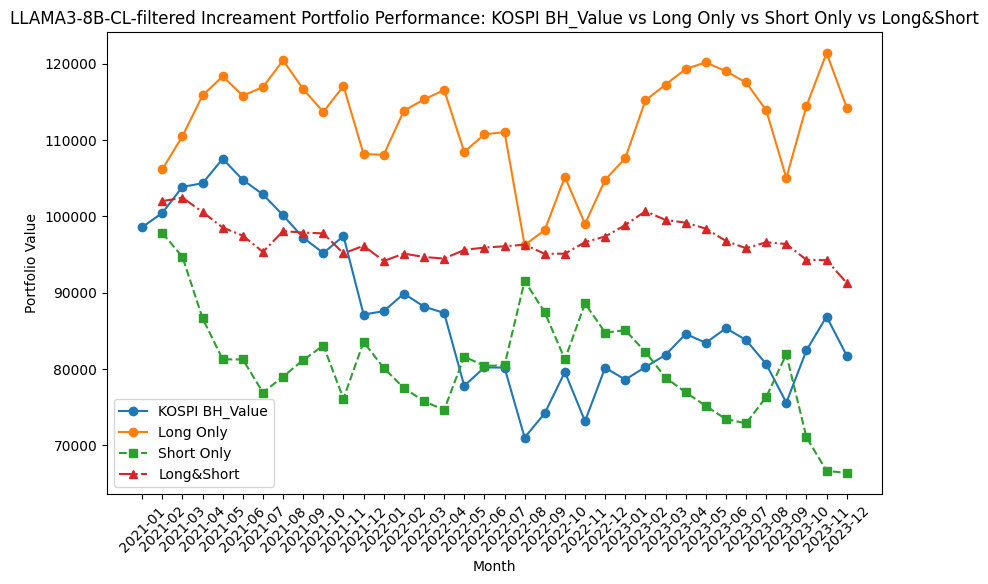

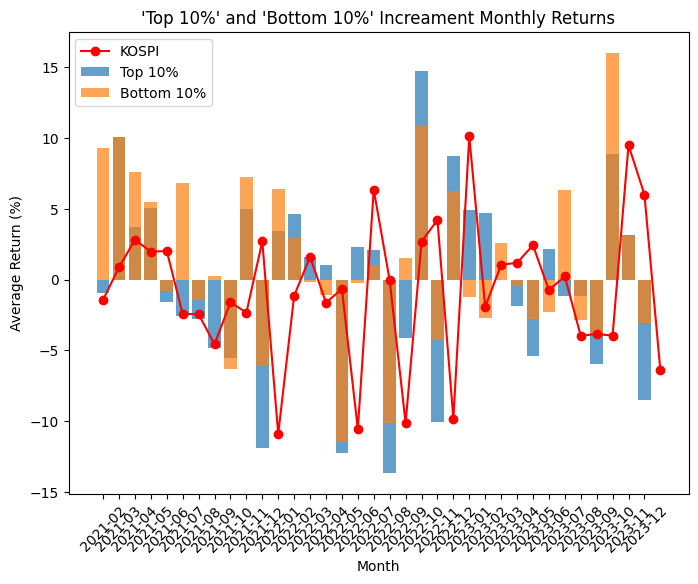

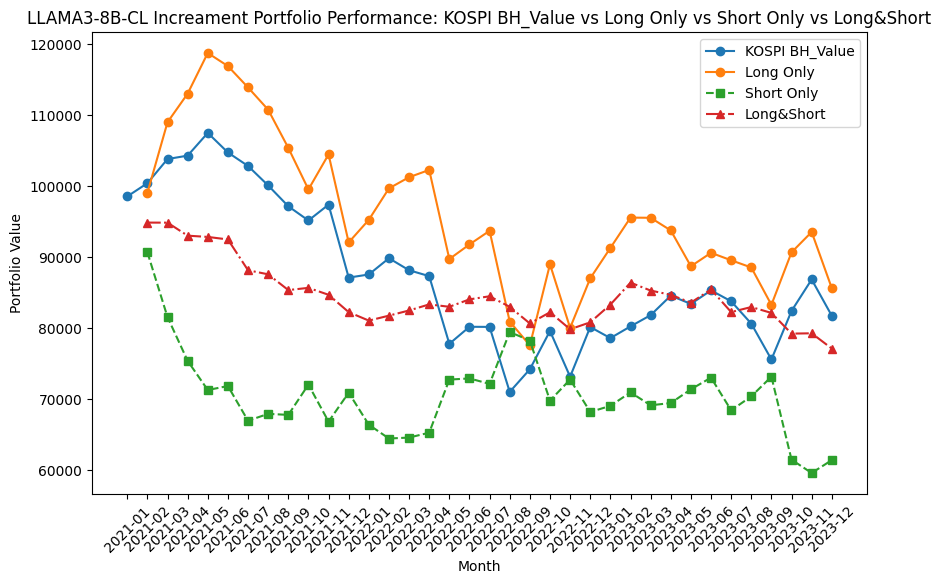

In [5]:
# data 폴더 경로 설정
data_folder = './data'

# data 폴더 내 모든 CSV 파일에 대한 리스트 생성
csv_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.csv')]

# 각 CSV 파일에 대해 함수 적용 및 결과 출력
for file_path in csv_files:
    try:
        df = compute_monthly_avg_pos_score(file_path)
        df = calculate_pct(df, file_path)
        evalueate_porto(df,file_path)
        print(f"Processing completed for {file_path}\n")
    except Exception as e:
        print(f"Error processing {file_path}: {e}\n")
